In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class grid():
    def __init__(self, n_x, n_y):
        self.n_x = n_x
        self.n_y = n_y
        self.x_points = np.empty(0)
        self.y_points = np.empty(0)
        self.x_max = 1000
        self.y_max = 1000
        self.grid = {}  
        self.elevation = {}
        self.grid_customers = {}  
        self.n_customers = 0      
        self.customer_points = {}
        self.depot = None
        self.d_ij_indices = {}    
        self.d_ij = None          # distances among customers - interface output for the optimization model
        self.d_ij_extended = None
        self.output_matrix = None
        self.tw_a = None
        self.tw_b = None
        self.load = None
        self.servicetime = 5 # minutes
        
        self.create_grid()
        self.grid_dict()
        
    def create_grid(self):
        delta_x = 20
        delta_y = 20
        np.random.seed(1)
        self.x_points = np.linspace(0, self.x_max, self.n_x+1) + np.random.randint(-delta_x, delta_x, self.n_x+1)
        self.y_points = np.linspace(0, self.y_max, self.n_y+1) + np.random.randint(-delta_y, delta_y, self.n_y+1)
        self.x_points[0] = 0; self.x_points[-1] = self.x_max
        self.y_points[0] = 0; self.y_points[-1] = self.y_max
        self.x_points.sort()
        self.y_points.sort()
        
    def grid_dict(self):
        for i in range(self.n_x+1):
            for j in range(self.n_y+1):
                self.grid[(i,j)] = (self.x_points[i], self.y_points[j])
                self.elevation[(i,j)] = 30*np.random.random()
        return self.grid
    
    def time_windows(self, tp='random', min_t=50, max_t=200, k_separation = 0.05, k_overlapped = 0.5):
        tw_a = np.zeros(1, dtype=int); tw_b = np.zeros(1, dtype=int)
        if tp == 'random':
            delta_lower = min_t/2
            delta_upper = delta_lower
            tw_center = np.random.randint(min_t+delta_lower, max_t-delta_upper, self.n_customers)
            self.tw_a = np.append(tw_a, tw_center - np.random.randint(0, delta_lower, self.n_customers))
            self.tw_b = np.append(tw_b, tw_center + np.random.randint(0, delta_upper, self.n_customers))
            return self.tw_a, self.tw_b
        if tp == 'separated':
            delta_tw = (max_t - min_t)/self.n_customers
            self.tw_a = np.append(tw_a, np.array([min_t + (i - k_separation)*delta_tw for i in range(self.n_customers)]) )
            self.tw_b = np.append(tw_b, np.array([min_t + (i + k_separation)*delta_tw for i in range(self.n_customers)]) )
            return self.tw_a, self.tw_b
        if tp == 'overlapped':
            tw_c = (max_t - min_t)/2
            tw_interval = 0.5*k_overlapped*tw_c # half base interval (centered halfway between max_t and min_t)
            delta_interval = np.random.randint(0, tw_interval, self.n_customers)
            self.tw_a = np.append(tw_a, np.array([min_t + tw_c - t for t in sorted(delta_interval)]) )
            self.tw_b = np.append(tw_b, np.array([min_t + tw_c + t for t in sorted(delta_interval)]) )
            # np.random.shuffle(tw_a); np.random.shuffle(tw_b)
            return self.tw_a, self.tw_b
        if tp == 'single':
            self.tw_a = np.append(tw_a, np.array([min_t for _ in range(self.n_customers)]) )
            self.tw_b = np.append(tw_b, np.array([max_t for _ in range(self.n_customers)]) )
            return self.tw_a, self.tw_b
    
    def payload(self, min_p=5, max_p=30):
        self.load = np.append(np.zeros(1), np.random.randint(min_p, max_p, self.n_customers))
    
    def plot_grid(self):
        for i in range(self.n_x+1):
            plt.plot([self.x_points[i], self.x_points[i]], [0, self.y_max], color='gray')
        for j in range(self.n_y+1):
            plt.plot([0, self.x_max], [self.y_points[j], self.y_points[j]], color='gray')
        
    def customers(self, n_customers):
        self.n_customers = n_customers
        random.seed(10); customer_points = random.sample(list(self.grid.items()), n_customers)
        self.customer_points = {k:v for k, v in customer_points}
        return self.customer_points
        
    def plot_customer_points(self):
        k = list(self.customer_points.values())
        self.plot_grid()
        for i in range(self.n_customers):
            plt.scatter(k[i][0], k[i][1])

    def customers_paths(self, depot):
        ### depot must be an appropriate tuple of coordinate indices of the grid: ex (12, 15): (12th pos. on x - 15th pos. on y)
        self.depot = depot
        nodes = list(self.customer_points.keys())
        nodes.insert(0, depot)
        print(nodes)
        delta_indices = np.zeros((self.n_customers+1, self.n_customers+1), dtype=object)
        for i in range(self.n_customers+1):
            print('node:', i, nodes[i])
            for j in range(self.n_customers+1):
                dx_index = nodes[i][0] - nodes[j][0]
                self.d_ij_indices[(i,j)] = ((nodes[i][0], nodes[i][1]), (nodes[i][0]-dx_index, nodes[i][1]), (nodes[j][0], nodes[j][1]))
        
        self.d_ij = np.zeros((self.n_customers+1, self.n_customers+1))
        self.d_ij_extended = np.zeros((2*self.n_customers+1, 2*self.n_customers+1))
        
        for k, v in self.d_ij_indices.items():
            dx = abs(self.grid[v[1]][0] - self.grid[v[0]][0])
            dy = abs(self.grid[v[2]][1] - self.grid[v[1]][1])
            
            self.d_ij[k[0], k[1]] = dx + dy
        
        return self.d_ij
    
    def create_csv(self):
        elevation = np.zeros(self.n_customers)
        service_time = np.zeros(1)
        for i, k in enumerate(self.customer_points.keys()):
            elevation[i] = self.elevation[k]
        elevation = np.append(self.elevation[self.depot], elevation)
        service_time = np.append(service_time, np.array([self.servicetime for _ in range(self.n_customers)]) )
        x = np.append(self.grid[self.depot][0], np.array([v[0] for v in self.customer_points.values()]) )
        y = np.append(self.grid[self.depot][1], np.array([v[1] for v in self.customer_points.values()]) )
        index = np.linspace(0,self.n_customers,self.n_customers+1)
        
        self.output_matrix = np.c_[index, x, y, elevation, self.load, self.tw_a, self.tw_b, service_time, self.d_ij/1000]
        
        header = ',x,y,elevation,demand,tw a,tw b,s'
        for i in range(self.n_customers+1):
            header += ','+str(i)
            
        np.savetxt('generated_grid_1.csv', self.output_matrix, delimiter=',', header=header, comments='')
        
        return self.output_matrix

In [3]:
G = grid(20, 20)
print(G.grid[(1,3)])
print(G.grid[(5,3)])

(42.0, 153.0)
(235.0, 153.0)


In [4]:
np.linspace(0,21,22)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21.])

In [5]:
np.append(np.zeros(1), np.random.randint(5, 10, 5))

array([0., 8., 9., 5., 6., 5.])

In [6]:
a,b = G.time_windows(tp='single', min_t= 50, max_t=400)
print(a)
print(b)

[0.]
[0.]


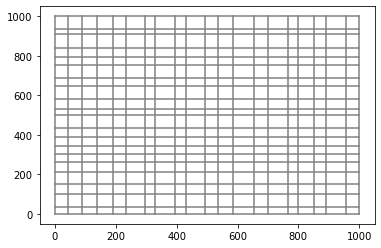

In [7]:
G.plot_grid()

In [8]:
print(np.round(G.x_points, 2))
print(np.round(G.y_points, 2))
print(G.n_x)

[   0.   42.   88.  139.  191.  235.  295.  330.  396.  431.  492.  537.
  586.  655.  700.  767.  798.  850.  891.  958. 1000.]
[   0.   34.  103.  153.  210.  262.  302.  343.  389.  437.  502.  531.
  580.  647.  688.  754.  793.  838.  910.  937. 1000.]
20


In [9]:
print(G.elevation[(0,0)])
print(G.elevation[(0,5)])

20.14962292266403
23.499434180846585


In [10]:
G.customers(20)
# for i in range(2,5): print(i)

{(13, 19): (655.0, 937.0),
 (0, 16): (0.0, 793.0),
 (10, 9): (492.0, 437.0),
 (11, 16): (537.0, 793.0),
 (14, 1): (700.0, 34.0),
 (0, 7): (0.0, 343.0),
 (5, 0): (235.0, 0.0),
 (11, 5): (537.0, 262.0),
 (19, 17): (958.0, 838.0),
 (11, 20): (537.0, 1000.0),
 (20, 1): (1000.0, 34.0),
 (6, 16): (295.0, 793.0),
 (15, 19): (767.0, 937.0),
 (19, 16): (958.0, 793.0),
 (3, 19): (139.0, 937.0),
 (0, 17): (0.0, 838.0),
 (12, 14): (586.0, 688.0),
 (11, 19): (537.0, 937.0),
 (7, 20): (330.0, 1000.0),
 (1, 17): (42.0, 838.0)}

In [11]:
# G.customer_points

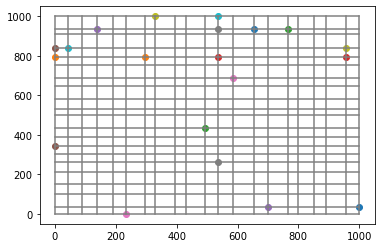

In [12]:
G.plot_customer_points()

In [13]:
G.customers_paths((0,0))

[(0, 0), (13, 19), (0, 16), (10, 9), (11, 16), (14, 1), (0, 7), (5, 0), (11, 5), (19, 17), (11, 20), (20, 1), (6, 16), (15, 19), (19, 16), (3, 19), (0, 17), (12, 14), (11, 19), (7, 20), (1, 17)]
node: 0 (0, 0)
node: 1 (13, 19)
node: 2 (0, 16)
node: 3 (10, 9)
node: 4 (11, 16)
node: 5 (14, 1)
node: 6 (0, 7)
node: 7 (5, 0)
node: 8 (11, 5)
node: 9 (19, 17)
node: 10 (11, 20)
node: 11 (20, 1)
node: 12 (6, 16)
node: 13 (15, 19)
node: 14 (19, 16)
node: 15 (3, 19)
node: 16 (0, 17)
node: 17 (12, 14)
node: 18 (11, 19)
node: 19 (7, 20)
node: 20 (1, 17)


array([[   0., 1592.,  793.,  929., 1330.,  734.,  343.,  235.,  799.,
        1796., 1537., 1034., 1088., 1704., 1751., 1076.,  838., 1274.,
        1474., 1330.,  880.],
       [1592.,    0.,  799.,  663.,  262.,  948., 1249., 1357.,  793.,
         402.,  181., 1248.,  504.,  112.,  447.,  516.,  754.,  318.,
         118.,  388.,  712.],
       [ 793.,  799.,    0.,  848.,  537., 1459.,  450., 1028., 1068.,
        1003.,  744., 1759.,  295.,  911.,  958.,  283.,   45.,  691.,
         681.,  537.,   87.],
       [ 929.,  663.,  848.,    0.,  401.,  611.,  586.,  694.,  220.,
         867.,  608.,  911.,  553.,  775.,  822.,  853.,  893.,  345.,
         545.,  725.,  851.],
       [1330.,  262.,  537.,  401.,    0.,  922.,  987., 1095.,  531.,
         466.,  207., 1222.,  242.,  374.,  421.,  542.,  582.,  154.,
         144.,  414.,  540.],
       [ 734.,  948., 1459.,  611.,  922.,    0., 1009.,  499.,  391.,
        1062., 1129.,  300., 1164.,  970., 1017., 1464., 1504.,  768.

In [14]:
# G.d_ij_indices

In [15]:
# G.d_ij

In [16]:
# print(G.grid_dict()[(0,0)])
# print(G.grid_dict()[(1,7)])
# print(G.grid_dict()[(16,23)])
# print(G.grid_dict()[(19,0)])

In [17]:
# G.customer_points

In [18]:
# for k in G.customer_points.keys():
#     print(k, ' elevation: ', G.elevation[k])

In [19]:
ta, tb = G.time_windows()
print(ta)
print(tb)

[  0  99 124  98 107  91  67 121 117  86  58  80  54  89  72  80 119 132
 149 171 112]
[  0 127 153 122 108 131  87 145 137 113  83  97  85 108  96 127 163 146
 165 176 139]


In [20]:
G.payload()

In [21]:
out = G.create_csv()

In [22]:
G1 = grid(10, 10)

In [23]:
G1.customers(20)

{(6, 7): (595.0, 691.0),
 (0, 4): (0.0, 417.0),
 (4, 10): (391.0, 1000.0),
 (5, 6): (485.0, 600.0),
 (0, 1): (0.0, 86.0),
 (2, 4): (188.0, 417.0),
 (5, 4): (485.0, 417.0),
 (9, 5): (881.0, 498.0),
 (5, 7): (485.0, 691.0),
 (9, 6): (881.0, 600.0),
 (3, 2): (289.0, 205.0),
 (7, 6): (680.0, 600.0),
 (9, 4): (881.0, 417.0),
 (1, 9): (92.0, 909.0),
 (6, 0): (595.0, 0.0),
 (3, 8): (289.0, 808.0),
 (0, 9): (0.0, 909.0),
 (2, 9): (188.0, 909.0),
 (8, 7): (796.0, 691.0),
 (4, 2): (391.0, 205.0)}

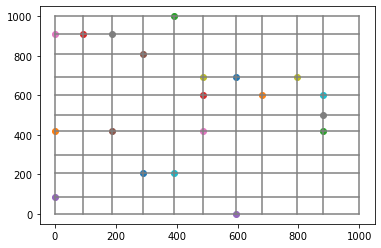

In [24]:
G1.plot_customer_points()

In [25]:
G1.customers_paths((0,0))

[(0, 0), (6, 7), (0, 4), (4, 10), (5, 6), (0, 1), (2, 4), (5, 4), (9, 5), (5, 7), (9, 6), (3, 2), (7, 6), (9, 4), (1, 9), (6, 0), (3, 8), (0, 9), (2, 9), (8, 7), (4, 2)]
node: 0 (0, 0)
node: 1 (6, 7)
node: 2 (0, 4)
node: 3 (4, 10)
node: 4 (5, 6)
node: 5 (0, 1)
node: 6 (2, 4)
node: 7 (5, 4)
node: 8 (9, 5)
node: 9 (5, 7)
node: 10 (9, 6)
node: 11 (3, 2)
node: 12 (7, 6)
node: 13 (9, 4)
node: 14 (1, 9)
node: 15 (6, 0)
node: 16 (3, 8)
node: 17 (0, 9)
node: 18 (2, 9)
node: 19 (8, 7)
node: 20 (4, 2)


array([[   0., 1286.,  417., 1391., 1085.,   86.,  605.,  902., 1379.,
        1176., 1481.,  494., 1280., 1298., 1001.,  595., 1097.,  909.,
        1097., 1487.,  596.],
       [1286.,    0.,  869.,  513.,  201., 1200.,  681.,  384.,  479.,
         110.,  377.,  792.,  176.,  560.,  721.,  691.,  423.,  813.,
         625.,  201.,  690.],
       [ 417.,  869.,    0.,  974.,  668.,  331.,  188.,  485.,  962.,
         759., 1064.,  501.,  863.,  881.,  584., 1012.,  680.,  492.,
         680., 1070.,  603.],
       [1391.,  513.,  974.,    0.,  494., 1305.,  786.,  677.,  992.,
         403.,  890.,  897.,  689., 1073.,  390., 1204.,  294.,  482.,
         294.,  714.,  795.],
       [1085.,  201.,  668.,  494.,    0.,  999.,  480.,  183.,  498.,
          91.,  396.,  591.,  195.,  579.,  702.,  710.,  404.,  794.,
         606.,  402.,  489.],
       [  86., 1200.,  331., 1305.,  999.,    0.,  519.,  816., 1293.,
        1090., 1395.,  408., 1194., 1212.,  915.,  681., 1011.,  823.

In [26]:
G1.time_windows()

(array([  0,  90,  62, 150, 158, 111, 110,  83,  86, 120, 137,  94,  88,
        155, 130,  64, 163,  85,  76, 156, 131]),
 array([  0, 123,  91, 178, 160, 127, 133, 107, 122, 133, 181, 125, 108,
        175, 164,  90, 179, 122, 100, 182, 152]))

In [27]:
G1.payload()

In [28]:
G1.create_csv()

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.01140253e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.28600000e+00, 4.17000000e-01, 1.39100000e+00,
        1.08500000e+00, 8.60000000e-02, 6.05000000e-01, 9.02000000e-01,
        1.37900000e+00, 1.17600000e+00, 1.48100000e+00, 4.94000000e-01,
        1.28000000e+00, 1.29800000e+00, 1.00100000e+00, 5.95000000e-01,
        1.09700000e+00, 9.09000000e-01, 1.09700000e+00, 1.48700000e+00,
        5.96000000e-01],
       [1.00000000e+00, 5.95000000e+02, 6.91000000e+02, 1.99032449e+01,
        1.50000000e+01, 9.00000000e+01, 1.23000000e+02, 5.00000000e+00,
        1.28600000e+00, 0.00000000e+00, 8.69000000e-01, 5.13000000e-01,
        2.01000000e-01, 1.20000000e+00, 6.81000000e-01, 3.84000000e-01,
        4.79000000e-01, 1.10000000e-01, 3.77000000e-01, 7.92000000e-01,
        1.76000000e-01, 5.60000000e-01, 7.21000000e-01, 6.91000000e-01,
        4.23000000e-01, 8.13000000e-01,